#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
clickstream_df = pd.read_parquet('../Data/clickstream_data.parquet.gzip')

In [3]:
clickstream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55967041 entries, 0 to 55967040
Data columns (total 9 columns):
 #   Column         Dtype   
---  ------         -----   
 0   event_time     object  
 1   event_type     category
 2   product_id     int32   
 3   category_id    int64   
 4   category_code  object  
 5   brand          object  
 6   price          float32 
 7   user_id        int32   
 8   user_session   object  
dtypes: category(1), float32(1), int32(2), int64(1), object(4)
memory usage: 2.8+ GB


In [4]:
clickstream_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,1005073,2232732093077520756,construction.tools.light,samsung,1130.020020,519698804,69b5d72f-fd6e-4fed-aa23-1286b2ca89a0
1,2020-01-01 00:00:01 UTC,view,1005192,2232732093077520756,construction.tools.light,meizu,205.669998,527767423,7f596032-ccbf-4643-9bad-e36a209512b4
2,2020-01-01 00:00:01 UTC,view,100063693,2053013552427434207,apparel.shirt,turtle,136.429993,519046195,d1e2f343-84bb-49bd-b13d-ca0f1ed9910e
3,2020-01-01 00:00:01 UTC,view,5100816,2232732103831716449,apparel.shoes,xiaomi,29.950001,518269232,0444841c-38ef-410c-b11f-7b35ea4e5991
4,2020-01-01 00:00:02 UTC,view,100014325,2232732103294845523,apparel.shoes.step_ins,intel,167.199997,587748686,31b7d4cf-dfac-4895-9927-90fa3254f860


## Exploratory Data Analysis

First we will perform some basic data analysis and then we will move on to the construction of our clickstream graphs. 

### Number of Events of Each Type

In [5]:
clickstream_df['event_type'].value_counts()

view        52490785
cart         2641249
purchase      835007
Name: event_type, dtype: int64

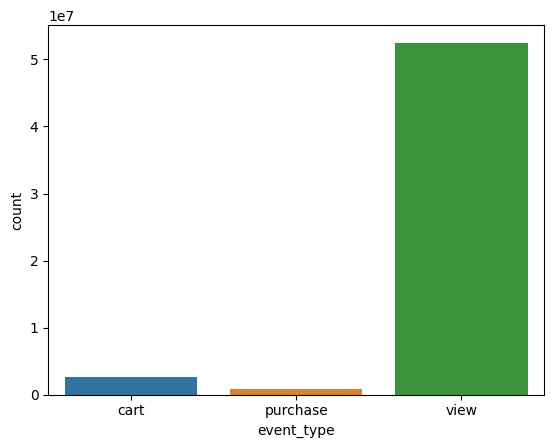

In [6]:
sns.countplot(x = clickstream_df['event_type'])
plt.show()

So, most of our events are views. There are :

    - Around 52.5 million views
    - Around 2.6 million add-to-cart events
    - Around 835K purchases

We could focus on just views for our analysis or could also look at all the three different events. 

### Number of Distinct Products, Users and Sessions Across Event Types

In [7]:
df = clickstream_df.groupby(['event_type'])[['product_id','user_id','user_session']].nunique().reset_index()
df

,event_type,product_id,user_id,user_session
0,cart,86993,740737,1543484
1,purchase,46951,359105,690930
2,view,226209,4383932,13757026


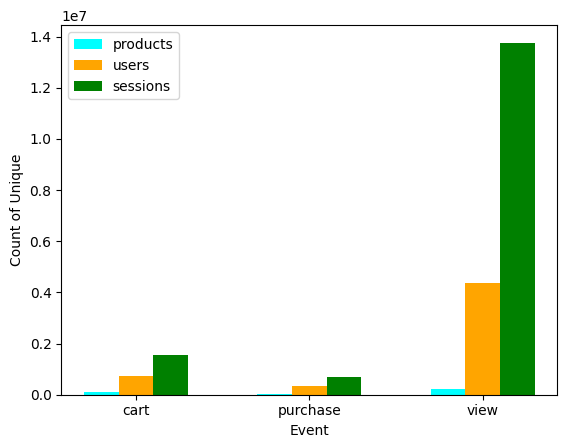

In [8]:
x = np.arange(3)
products = df['product_id']
users = df['user_id']
sessions = df['user_session']
width = 0.2
  
# Plotting grouped bar charts
plt.bar(x - 0.2, products, width, color='cyan')
plt.bar(x, users, width, color='orange')
plt.bar(x + 0.2, sessions, width, color='green')
plt.xticks(x, ['cart', 'purchase', 'view'])
plt.xlabel("Event")
plt.ylabel("Count of Unique")
plt.legend(["products", "users", "sessions"])
plt.show()

So we see that for views, we have a lot of unique sessions as compared to unique users or products. For purchases and add to car events, the difference is less stark. It would seem that users who only intend to view the products, do so over several sessions and are not quite determined to buy unlike the users who have purchased. Perhaps, this is indicative of 'window shopping'. 

### Checking for NULL values

In [9]:
clickstream_df.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    5044890
brand            6540255
price                  0
user_id                0
user_session          19
dtype: int64

So, thankfully it seems that we do not have any null sessions, that is, any sessions where user_id, product_id is NULL.However, we do seem to have some sessions where the session_id (user_session) is NULL. Let us look at these distributions based on event type.

In [10]:
clickstream_df[clickstream_df['event_type']=='view'].isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4794127
brand            6283941
price                  0
user_id                0
user_session           0
dtype: int64

In [11]:
clickstream_df[clickstream_df['event_type']=='cart'].isna().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    201380
brand            204055
price                 0
user_id               0
user_session         19
dtype: int64

In [12]:
clickstream_df[clickstream_df['event_type']=='purchase'].isna().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    49383
brand            52259
price                0
user_id              0
user_session         0
dtype: int64

So we see that the 19 NULL values in user_session appear for the 'cart' event type. We will simply drop those entries. 

In [13]:
clickstream_df.dropna(subset=['user_session'], axis=0, inplace=True)

### Distribution of  Number of Unique Events per Session 

#### Distribution of unique product views per session

In [14]:
views_per_sess = clickstream_df[clickstream_df['event_type']=='view'].groupby(['user_session'])[['product_id']].nunique()
print(views_per_sess['product_id'].mean())
print(views_per_sess['product_id'].median())

2.6224088694751324
1.0


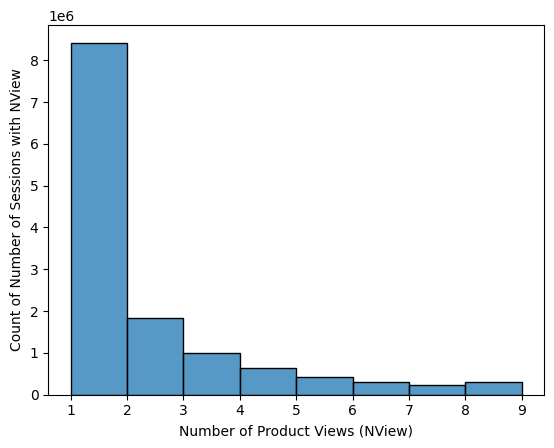

In [15]:
sns.histplot(views_per_sess[views_per_sess['product_id']<10]['product_id'], binwidth = 1)
plt.xlabel("Number of Product Views (NView)")
plt.ylabel("Count of Number of Sessions with NView")
plt.show()

 - So we see that the average number of product views per session is between 2 and 3.
 - The median number of product views per session is 1.
 - From the histogram as well, we can see that the maximum number of views per session is concentrated between 1 and 4.

#### Distribution of unique product cart additions per session

In [16]:
cart_per_sess = clickstream_df[clickstream_df['event_type']=='cart'].groupby(['user_session'])[['product_id']].nunique()
print(cart_per_sess['product_id'].mean())
print(cart_per_sess['product_id'].median())

1.152015181239326
1.0


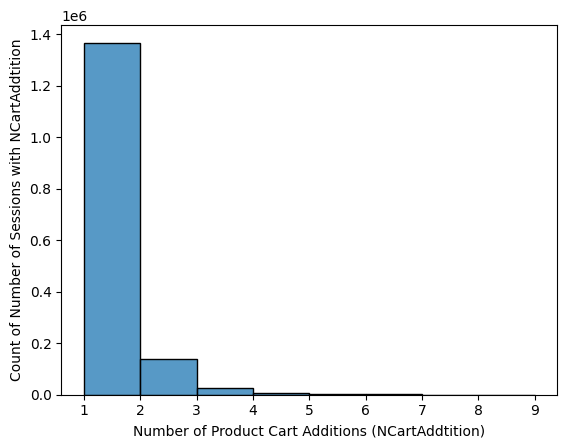

In [17]:
sns.histplot(cart_per_sess[cart_per_sess['product_id']<10]['product_id'], binwidth = 1)
plt.xlabel("Number of Product Cart Additions (NCartAddtition)")
plt.ylabel("Count of Number of Sessions with NCartAddtition")
plt.show()

 - So we see that the average number of product cart additions per session is close to 1.
 - The median number of product purchases per session is 1.
 - From the histogram as well, we can see that the maximum number of cart additions per session is concentrated between 1 and 3.

#### Distribution of unique product purchases per session

In [18]:
purchase_per_sess = clickstream_df[clickstream_df['event_type']=='purchase'].groupby(['user_session'])[['product_id']].nunique()
print(purchase_per_sess['product_id'].mean())
print(purchase_per_sess['product_id'].median())

1.1229183853646534
1.0


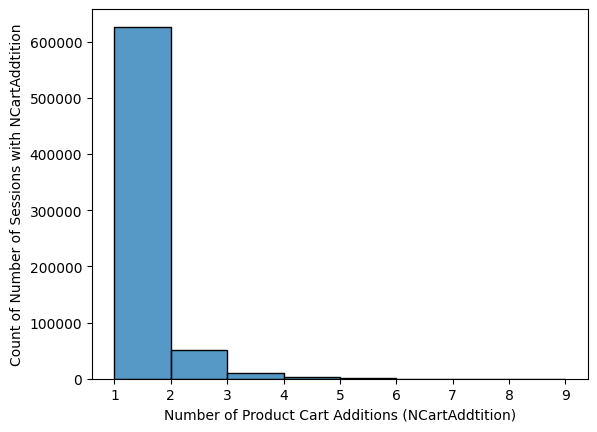

In [19]:
sns.histplot(purchase_per_sess[purchase_per_sess['product_id']<10]['product_id'], binwidth = 1)
plt.xlabel("Number of Product Cart Additions (NCartAddtition)")
plt.ylabel("Count of Number of Sessions with NCartAddtition")
plt.show()

 - So we see that the average number of product purchases per session is close to 1.
 - The median number of product views per session is 1.
 - From the histogram as well, we can see that the maximum number of purchases per session is concentrated between 1 and 3.

### Number of user sessions with at more than 1 unique event for each event type

We already saw from our past analysis that the number of unique sessions for every event type with at least 1 event was as follows :

       - Added To Cart : 1.5+ million
       - Purchased : 690K
       - Viewed : 13.75+ million

 We will now look at sessions which had more than 1 unique event for each event type.

In [20]:
print("No. of unique session with more than 1 product view",len(views_per_sess[views_per_sess['product_id']>1]))
print("No. of unique session with more than 1 product cart addition",len(cart_per_sess[cart_per_sess['product_id']>1]))
print("No. of unique session with more than 1 product purchase",len(purchase_per_sess[purchase_per_sess['product_id']>1]))


No. of unique session with more than 1 product view 5340115
No. of unique session with more than 1 product cart addition 176004
No. of unique session with more than 1 product purchase 64473


So, the number of sessions which had more than 1 unique event for each event type can be summarized as follows:  

       - Added To Cart : 176K
       - Purchased : 64.4K
       - Viewed : 5.34+ million

## Summary of Insights from EDA

 - Most of our events are views. There are :

      - Around 52.5 million views
      - Around 2.6 million add-to-cart events
      - Around 835K purchases
    
 - For views, we have a lot of unique sessions as compared to unique users or products. For purchases and add to car events, the difference is less stark. 
 
 - Views Per Session : 
 
       - The average number of product views per session is between 2 and 3.
       - The median number of product views per session is 1.
     
 - Cart Additions Per Session : 
 
       - The average number of product cart additions per session is close to 1.
       - The median number of product cart additions per session is 1.
     
 - Purchases Per Session : 
 
       - The average number of product purchases per session is close to 1.
       - The median number of product purchases per session is 1.
     
 - The number of unique sessions for every event type with at least 1 event was as follows :
 
       - Added To Cart : 1.5+ million
       - Purchased : 690K
       - Viewed : 13.75+ million
       
 - The number of sessions which had more than 1 unique event for each event type can be summarized as follows:  

       - Added To Cart : 176K
       - Purchased : 64.4K
       - Viewed : 5.34+ million

## Constructing the Graphs

We will now try and contruct the co-occurrence graphs for user journey across the various event types using our clickstream data. To understand that, take a look at the dummy example below (with the example of characters from The Office :D )

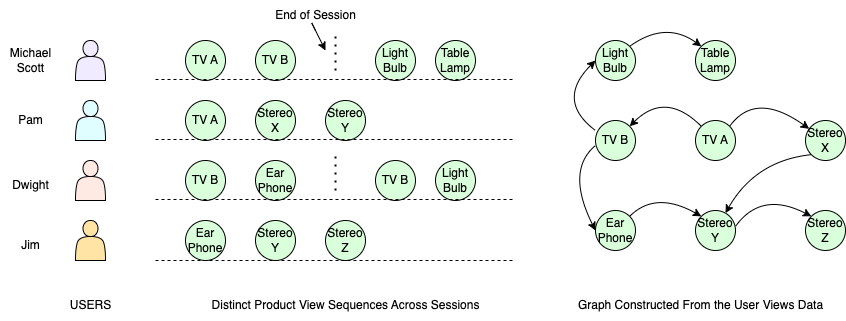

 - Michael has viewed some items like TV A, then TV B and Light Bulb, then Table Lamp across two sessions. 
 - Pam has viewed TV A, followed by Stereo X followed by Stereo Y in one session.
 - Dwight has viewed TV B followed by Ear Phone and TV B followed by Light Bulb in two sessions.
 - Jim has viewed Ear Phone, followed by Stereo Y followed by Stereo Z in one session. 
 
The graph on the right shows what the user journey graph might look like, if we constructed it from this dummy clickstream data. We do not have same product in succession in each of the sessions, since we do not really want self loops in the graph for now.

 ### Graphs for Product Views
 
Let us say we wanted to show Michael the latest releases in flat screen ultra HD TVs, while he was currently viewing some related products like TVs and Monitors. In this case, we would perhaps need to look at the co-occurrence graph for views. We will first contruct the graph for views.
 
For this purpose we shall consider sessions with more than 1 views. Let us first get those sessions.

In [21]:
clickstream_df['event_time'] = clickstream_df['event_time'].str.rstrip('UTC')
clickstream_df['event_time'] = pd.to_datetime(clickstream_df['event_time'])

views = clickstream_df[clickstream_df['event_type']=='view']
cart = clickstream_df[clickstream_df['event_type']=='cart']
purchase = clickstream_df[clickstream_df['event_type']=='purchase']

In [22]:
# Sessions with more than 1 unique views
unique_views_sessions = views_per_sess[views_per_sess['product_id']>1].reset_index()['user_session'].values

# Getting entries corresponding to the sessions obtained above
unique_views = views.loc[views['user_session'].isin(unique_views_sessions)][['user_id', 'product_id', 'event_time', 'user_session']]

Let us look at the example of a single session and what it would look like if we were to construct a graph on it.

In [23]:
unique_views[unique_views['user_session'] == '60847f01-db4d-4a73-a11a-8034e177e006']

,user_id,product_id,event_time,user_session
53270207,605295014,3700926,2020-01-30 16:37:20,60847f01-db4d-4a73-a11a-8034e177e006
53270766,605295014,3700677,2020-01-30 16:37:36,60847f01-db4d-4a73-a11a-8034e177e006
53274015,605295014,3701241,2020-01-30 16:39:04,60847f01-db4d-4a73-a11a-8034e177e006
53276984,605295014,3701241,2020-01-30 16:40:26,60847f01-db4d-4a73-a11a-8034e177e006
53286940,605295014,3701190,2020-01-30 16:44:43,60847f01-db4d-4a73-a11a-8034e177e006
53291977,605295014,100067814,2020-01-30 16:46:56,60847f01-db4d-4a73-a11a-8034e177e006
53292418,605295014,100067814,2020-01-30 16:47:10,60847f01-db4d-4a73-a11a-8034e177e006
53295764,605295014,3700557,2020-01-30 16:48:40,60847f01-db4d-4a73-a11a-8034e177e006
53296705,605295014,3700557,2020-01-30 16:49:03,60847f01-db4d-4a73-a11a-8034e177e006
53299822,605295014,3700557,2020-01-30 16:50:28,60847f01-db4d-4a73-a11a-8034e177e006


#### Getting the next product 

In [24]:
unique_views['next_product_id'] = unique_views.sort_values(by = 'event_time').groupby('user_session')['product_id'].shift(-1, fill_value=-1)
order_cols = ['user_id','product_id','next_product_id','event_time','user_session']
unique_views = unique_views[order_cols]

#### An example sub graphs for a user session

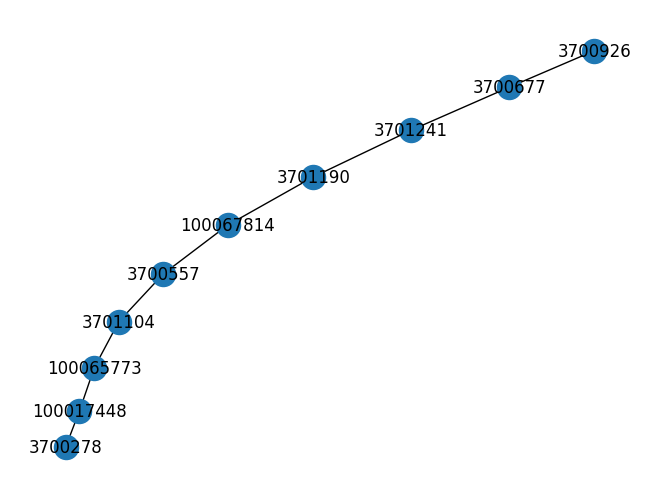

In [25]:
example = unique_views[unique_views['user_session'] == '60847f01-db4d-4a73-a11a-8034e177e006']
example = example[(example['next_product_id'] != example['product_id']) & (example['next_product_id'] != -1)]
edge_list = [[x[0], x[1]] for x in example[['product_id', 'next_product_id']].to_numpy()]


G = nx.Graph()
G.add_edges_from(edge_list)
nx.draw(G, with_labels=True)
plt.show()

#### Directed, Unweighted Graph for Views

In [26]:
dir_unweight_graph_views = unique_views[(unique_views['next_product_id'] != unique_views['product_id']) & (unique_views['next_product_id'] != -1)]
dir_unweight_graph_views = dir_unweight_graph_views[['product_id', 'next_product_id']]
print(len(dir_unweight_graph_views))
dir_unweight_graph_views.to_parquet('../Data/Graphs/dir_unweight_graph_views.parquet',index=False)

25876392


#### Directed, Weighted Graph for Views

In [27]:
dir_weight_graph_views = unique_views[(unique_views['next_product_id'] != unique_views['product_id']) & (unique_views['next_product_id'] != -1)]
dir_weight_graph_views = dir_weight_graph_views.groupby(['product_id','next_product_id'])[['event_time']].count().reset_index()
dir_weight_graph_views = dir_weight_graph_views[['product_id', 'next_product_id','event_time']].rename(columns={'event_time':'count'})
print(len(dir_weight_graph_views))
dir_weight_graph_views.to_parquet('../Data/Graphs/dir_weight_graph_views.parquet',index=False)


8415223


#### Undirected, Weighted Graph for Views

In [28]:
pd.set_option('mode.chained_assignment', None)
undir_weight_graph_views = unique_views[(unique_views['next_product_id'] != unique_views['product_id']) & (unique_views['next_product_id'] != -1)]
undir_weight_graph_views['product_id1'] = np.where(undir_weight_graph_views['product_id']>undir_weight_graph_views['next_product_id'], 
                                                   undir_weight_graph_views['product_id'],
                                                   undir_weight_graph_views['next_product_id'])

undir_weight_graph_views['product_id2'] = np.where(undir_weight_graph_views['product_id']<undir_weight_graph_views['next_product_id'], 
                                                   undir_weight_graph_views['product_id'],
                                                   undir_weight_graph_views['next_product_id'])

undir_weight_graph_views = undir_weight_graph_views[['product_id1', 'product_id2','event_time']].rename(columns={'event_time':'count'})
undir_weight_graph_views = undir_weight_graph_views.groupby(['product_id1','product_id2'])[['count']].count().reset_index()

print(len(undir_weight_graph_views))
undir_weight_graph_views.to_parquet('../Data/Graphs/undir_weight_graph_views.parquet',index=False)


6844525


### Graphs for Product Purchases

Now let's say Pam purchased a Monitor. Perhaps we also want to recommend a keyboard, a mouse and a headphone to her ? Maybe she is planning to set up a workstation. In this case, we would want to construct our graph from purchase data. 

In [29]:
# Sessions with more than 1 unique purchases
unique_purchases_sessions = purchase_per_sess[purchase_per_sess['product_id']>1].reset_index()['user_session'].values

# Getting entries corresponding to the sessions obtained above
unique_purchases = purchase.loc[purchase['user_session'].isin(unique_purchases_sessions)][['user_id', 'product_id', 'event_time', 'user_session']]


# Getting next product
unique_purchases['next_product_id'] = unique_purchases.sort_values(by = 'event_time').groupby('user_session')['product_id'].shift(-1, fill_value=-1)
unique_purchases = unique_purchases[order_cols]


#### Directed, Unweighted Graph for Purchases

In [30]:
dir_unweight_graph_purchases = unique_purchases[(unique_purchases['next_product_id'] != unique_purchases['product_id']) & (unique_purchases['next_product_id'] != -1)]
dir_unweight_graph_purchases = dir_unweight_graph_purchases[['product_id', 'next_product_id']]
print(len(dir_unweight_graph_purchases))
dir_unweight_graph_purchases.to_parquet('../Data/Graphs/dir_unweight_graph_purchases.parquet',index=False)


86980


#### Directed, Weighted Graph for Purchases

In [31]:
dir_weight_graph_purchases = unique_purchases[(unique_purchases['next_product_id'] != unique_purchases['product_id']) & (unique_purchases['next_product_id'] != -1)]
dir_weight_graph_purchases = dir_weight_graph_purchases.groupby(['product_id','next_product_id'])[['event_time']].count().reset_index()
dir_weight_graph_purchases = dir_weight_graph_purchases[['product_id', 'next_product_id','event_time']].rename(columns={'event_time':'count'})
print(len(dir_weight_graph_purchases))
dir_weight_graph_purchases.to_parquet('../Data/Graphs/dir_weight_graph_purchases.parquet',index=False)


53733


#### Undirected, Weighted Graph for Purchases

In [32]:
undir_weight_graph_purchases = unique_purchases[(unique_purchases['next_product_id'] != unique_purchases['product_id']) & (unique_purchases['next_product_id'] != -1)]
undir_weight_graph_purchases['product_id1'] = np.where(undir_weight_graph_purchases['product_id']>undir_weight_graph_purchases['next_product_id'], 
                                                   undir_weight_graph_purchases['product_id'],
                                                   undir_weight_graph_purchases['next_product_id'])

undir_weight_graph_purchases['product_id2'] = np.where(undir_weight_graph_purchases['product_id']<undir_weight_graph_purchases['next_product_id'], 
                                                   undir_weight_graph_purchases['product_id'],
                                                   undir_weight_graph_purchases['next_product_id'])

undir_weight_graph_purchases = undir_weight_graph_purchases[['product_id1', 'product_id2','event_time']].rename(columns={'event_time':'count'})
undir_weight_graph_purchases = undir_weight_graph_purchases.groupby(['product_id1','product_id2'])[['count']].count().reset_index()

print(len(undir_weight_graph_purchases))
undir_weight_graph_purchases.to_parquet('../Data/Graphs/undir_weight_graph_purchases.parquet',index=False)


49328


### Graphs for Product Cart Additions

In [33]:
# Sessions with more than 1 unique purchases
unique_cart_sessions = cart_per_sess[cart_per_sess['product_id']>1].reset_index()['user_session'].values

# Getting entries corresponding to the sessions obtained above
unique_cart = cart.loc[cart['user_session'].isin(unique_cart_sessions)][['user_id', 'product_id', 'event_time', 'user_session']]


# Getting next product
unique_cart['next_product_id'] = unique_cart.sort_values(by = 'event_time').groupby('user_session')['product_id'].shift(-1, fill_value=-1)
unique_cart = unique_cart[order_cols]


#### Directed, Unweighted Graph for Purchases

In [34]:
dir_unweight_graph_cart = unique_cart[(unique_cart['next_product_id'] != unique_cart['product_id']) & (unique_cart['next_product_id'] != -1)]
dir_unweight_graph_cart = dir_unweight_graph_cart[['product_id', 'next_product_id']]
print(len(dir_unweight_graph_cart))
dir_unweight_graph_cart.to_parquet('../Data/Graphs/dir_unweight_graph_cart.parquet',index=False)


252503


#### Directed, Weighted Graph for Purchases

In [35]:
dir_weight_graph_cart = unique_cart[(unique_cart['next_product_id'] != unique_cart['product_id']) & (unique_cart['next_product_id'] != -1)]
dir_weight_graph_cart = dir_weight_graph_cart.groupby(['product_id','next_product_id'])[['event_time']].count().reset_index()
dir_weight_graph_cart = dir_weight_graph_cart[['product_id', 'next_product_id','event_time']].rename(columns={'event_time':'count'})
print(len(dir_weight_graph_cart))
dir_weight_graph_cart.to_parquet('../Data/Graphs/dir_weight_graph_cart.parquet',index=False)


149766


#### Undirected, Weighted Graph for Purchases

In [36]:
undir_weight_graph_cart = unique_cart[(unique_cart['next_product_id'] != unique_cart['product_id']) & (unique_cart['next_product_id'] != -1)]
undir_weight_graph_cart['product_id1'] = np.where(undir_weight_graph_cart['product_id']>undir_weight_graph_cart['next_product_id'], 
                                                   undir_weight_graph_cart['product_id'],
                                                   undir_weight_graph_cart['next_product_id'])

undir_weight_graph_cart['product_id2'] = np.where(undir_weight_graph_cart['product_id']<undir_weight_graph_cart['next_product_id'], 
                                                   undir_weight_graph_cart['product_id'],
                                                   undir_weight_graph_cart['next_product_id'])

undir_weight_graph_cart = undir_weight_graph_cart[['product_id1', 'product_id2','event_time']].rename(columns={'event_time':'count'})
undir_weight_graph_cart = undir_weight_graph_cart.groupby(['product_id1','product_id2'])[['count']].count().reset_index()

print(len(undir_weight_graph_cart))
undir_weight_graph_cart.to_parquet('../Data/Graphs/undir_weight_graph_cart.parquet',index=False)


131783


So now we are done with graph creation. We have saved our graphs (directed & unweighted, directed & weighted, undirected & weighted) for the three event types : views, purchases and cart additions.

#### End